In [1]:
# Imports
# Gymnasium imports
import gymnasium as gym
from gymnasium import Env
from gymnasium.spaces import Discrete, Box, Dict, Tuple, MultiBinary, MultiDiscrete

import networkx as nx
from networkx.drawing.nx_agraph import graphviz_layout

# Import helpers
import numpy as np
import pandas as pd
import random
import os
import json
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import product
from pathlib import Path
import pickle

from collections import deque

# Import stable baselines
from stable_baselines3 import PPO, A2C
from stable_baselines3.common.vec_env import VecFrameStack, DummyVecEnv, VecNormalize
from stable_baselines3.common.env_util import make_vec_env, SubprocVecEnv
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.env_checker import check_env

from Environment.env_v8 import *
from Functions.visualization_functions import *

In [11]:
# Configuration of the network
with open("./Config/network_config_v1.json") as file:
    network_config = file.read()

EP_LENGTH = 100  # Length of the episode

/Users/jonasrenfer/miniconda3/envs/rl-scm/lib/python3.12/site-packages/stable_baselines3/common/env_checker.py:263: UserWarning: Your observation order_queues has an unconventional shape (neither an image, nor a 1D vector). We recommend you to flatten the observation to have only a 1D vector or use a custom policy to properly process the data.
  warnings.warn(


Node Attributes:
Node A: {'type': 'manufacturer', 'I': 30}
Node B: {'type': 'manufacturer', 'I': 30}
Node C: {'type': 'manufacturer', 'I': 30}
Node D: {'type': 'distributor'}
Node S: {'type': 'source'}


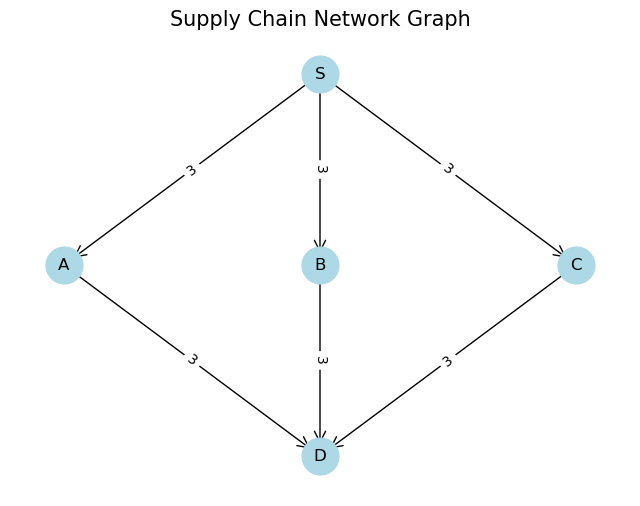

In [12]:
def load_config(config_file):

    with open(config_file, "r") as f:
        config = json.load(f)
    return config

def make_env(config_file="config.json"):

    config = load_config(config_file)

    env = SS_Mngmt_Env(
        network_config=network_config,
        EP_LENGTH=EP_LENGTH,
        render_mode="human",
        model_type="PPO",
        stockout_cost=config["stockout_cost"],
        order_cost=config["order_cost"],
        item_cost=config["item_cost"],
        stock_cost=config["stock_cost"],
        item_prize=config["item_prize"],
        progressive_stock_cost=config["progressive_stock_cost"],
        stock_out_max=config["stock_out_max"],
        order_quantities=config["order_quantities"],
        demand_mean=config["demand_mean"],
        demand_std=config["demand_std"],
        demand_noise=config["demand_noise"],
        demand_noise_std=config["demand_noise_std"],
        demand_prob=config["demand_prob"],
    )

    return Monitor(env)

env = make_env("./Config/env_config_v0.json")
check_env(env, warn=True)

In [14]:
vec_env = DummyVecEnv([lambda: make_env()])
vec_env = VecNormalize(vec_env, norm_obs=True, norm_reward=True, clip_obs=10.0)

In [15]:
import optuna

def optimize_hyperparams(trial):
    lr = trial.suggest_float("learning_rate", 1e-5, 1e-2)
    gamma = trial.suggest_float("gamma", 0.9, 0.999)
    ent_coef = trial.suggest_float("ent_coef", 1e-4, 1e-1)
    vf_coef = trial.suggest_float("vf_coef", 0.5, 1.0)
    
    model = PPO("MultiInputPolicy", vec_env, learning_rate=lr, gamma=gamma, ent_coef=ent_coef, vf_coef=vf_coef, verbose=0)
    model.learn(total_timesteps=500_000)
    
    rewards, _ = evaluate_policy(model, env, n_eval_episodes=5, return_episode_rewards=True)
    return sum(rewards) / len(rewards)

study = optuna.create_study(direction="maximize")
study.optimize(optimize_hyperparams, n_trials=50)
print("Best parameters:", study.best_params)

/Users/jonasrenfer/miniconda3/envs/rl-scm/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[I 2024-12-01 17:37:29,316] A new study created in memory with name: no-name-464935c8-698d-4306-af70-be2ad8259d61
/var/folders/cz/9b93tcz93vxcjrq9_cqhnl3r0000gn/T/ipykernel_36306/1293110084.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
/var/folders/cz/9b93tcz93vxcjrq9_cqhnl3r0000gn/T/ipykernel_36306/1293110084.py:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float in

Best parameters: {'learning_rate': 2.2189718765848422e-05, 'gamma': 0.9256844451434815, 'ent_coef': 0.0003461669566825764, 'vf_coef': 0.5398884275649528}


In [21]:
now = datetime.now()

# Save the study to a file
with open(f"./Training/PPO_optuna_study_{now.strftime("%Y-%m-%d_%H_%M")}.pkl", "wb") as f:
    pickle.dump(study, f)

In [2]:
# Load the study from a file
with open("./Training/PPO_optuna_study_2024-12-01_19_02.pkl", "rb") as f:
    study = pickle.load(f)

print("Best parameters from loaded study:", study.best_params)

Best parameters from loaded study: {'learning_rate': 2.2189718765848422e-05, 'gamma': 0.9256844451434815, 'ent_coef': 0.0003461669566825764, 'vf_coef': 0.5398884275649528}


/Users/jonasrenfer/miniconda3/envs/rl-scm/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


**Plot Optimization History**

This plot shows the best trial value at each step of the optimization process.

In [3]:
from optuna.visualization import plot_optimization_history

fig = plot_optimization_history(study)
fig.show()

**Plot Hyperparameter Importance**

This plot estimates the relative importance of each hyperparameter based on how they affect the objective function.

In [3]:
from optuna.visualization import plot_param_importances

fig = plot_param_importances(study)
fig.show()

**Parallel Coordinate Plot**

This plot helps visualize the relationships between hyperparameters and the objective value. It’s useful for spotting trends or correlations.

In [5]:
from optuna.visualization import plot_parallel_coordinate

fig = plot_parallel_coordinate(study)
fig.show()

**Slice Plot**

This plot visualizes the objective value across the range of each hyperparameter, helping understand how each parameter influences the outcome.

In [6]:
from optuna.visualization import plot_slice

fig = plot_slice(study)
fig.show()

**Contour Plot**

This plot shows the relationship between two hyperparameters and their influence on the objective value.

In [7]:
from optuna.visualization import plot_contour

fig = plot_contour(study)
fig.show()